In [232]:
# import packages
import datetime
import pandas as pd
import sklearn
pd.options.display.max_columns = None
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import umap
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.regularizers import l2, l1
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')

In [233]:
df = pd.read_csv('faults.csv')
df.columns = map(str.lower, df.columns)
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas']
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults']
enc_dict = {'pastry' : 0,
            'z_scratch' : 1,
            'k_scatch' : 2,
            'stains' : 3,
            'dirtiness' : 4,
            'bumps' : 5,
            'other_faults' : 6}
df.drop(391, inplace = True)
df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)
sm = SMOTE()
X = df[feat_col]
y = df['anomaly']
X_res, y_res = sm.fit_resample(X, y)
df_res = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), right_index = True, left_index = True)
df_nonbin = df_res.drop(['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly'], axis = 1)#.drop(target_cols, axis = 1)
sc = StandardScaler()
nonbin_norm = sc.fit_transform(df_nonbin)
df_nonbin_norm = pd.DataFrame(nonbin_norm, columns = df_nonbin.columns)
df_norm = df_nonbin_norm.copy()
df_norm[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']] = df_res[['typeofsteel_a300', 'typeofsteel_a400', 'outside_global_index', 'anomaly']]
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)
df_norm.drop(['y_minimum', 'y_maximum', 'typeofsteel_a400'], axis = 1, inplace = True)
df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)
df_norm.drop(['x_minimum', 'x_maximum'], axis = 1, inplace = True)
df_norm['aggregate3'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)
df_norm['aggregate4'] = df_norm[['y_perimeter', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['y_perimeter'], axis = 1, inplace = True)
df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'pixels_areas']].mean(axis = 1)
df_norm.drop(['pixels_areas'], axis = 1, inplace = True)
df_norm['aggregate6'] = df_norm[['sum_of_luminosity', 'x_perimeter']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter'], axis = 1, inplace = True)
df_norm.dropna(inplace = True)
df_norm = df_norm.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 18]] # reorder columns

In [234]:
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']
y = tf.keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [235]:
# input layer
input_layer = Input(shape = (X.shape[1],))

# hidden layers
x = Dense(256, activation = LeakyReLU(), kernel_regularizer = l2(1e-5))(input_layer)
#x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(128, activation = LeakyReLU(), kernel_regularizer = l2(1e-5))(input_layer)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(128, activation = LeakyReLU(), kernel_regularizer = l2(1e-5))(x)
x = Dense(64, activation = LeakyReLU(), kernel_regularizer = l2(1e-5))(x)
#x = Dropout(0.3)(x)
x = Dense(32, activation = LeakyReLU())(x)
x = Dense(16, activation = LeakyReLU())(x)

# decision layer
output_classification = Dense(7, activation = 'softmax', name = "classification")(x)

model = Model(inputs = input_layer, outputs = output_classification)

model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.CategoricalFocalCrossentropy(alpha = [0.8, 1, 1, 1, 1, 0.5, 0.4], gamma = 2), 
              metrics = ['accuracy'])

In [236]:
history = model.fit(
    X_train, y_train,
    batch_size = 256,
    epochs = 100,
    shuffle = True,
    validation_split = 0.2,
    verbose = 1
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.2844 - loss: 1.0566 - val_accuracy: 0.5530 - val_loss: 0.7698
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5462 - loss: 0.5090 - val_accuracy: 0.6273 - val_loss: 0.5463
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6453 - loss: 0.3563 - val_accuracy: 0.7106 - val_loss: 0.4463
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7081 - loss: 0.2901 - val_accuracy: 0.7652 - val_loss: 0.3737
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7470 - loss: 0.2322 - val_accuracy: 0.7939 - val_loss: 0.3322
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7878 - loss: 0.1912 - val_accuracy: 0.8030 - val_loss: 0.2866
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8000 - loss: 0.1720 - val_accuracy: 0.8106 - val_loss: 0.2525
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8134 - loss: 0.1500 - val_accuracy: 0

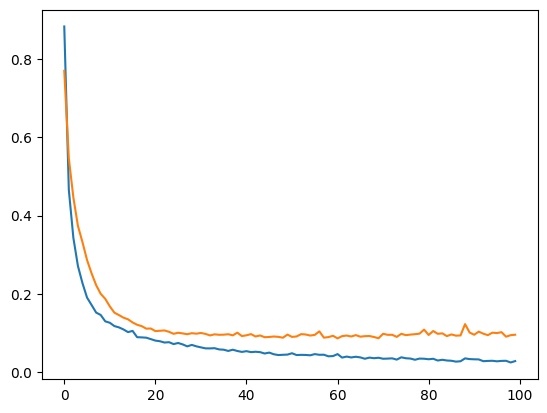

In [237]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim(0, 0.1)
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy of NN: 0.89%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       212
           1       0.93      0.97      0.95       204
           2       0.99      0.99      0.99       205
           3       0.97      1.00      0.98       188
           4       0.96      1.00      0.98       197
           5       0.74      0.81      0.78       199
           6       0.78      0.56      0.65       209

    accuracy                           0.89      1414
   macro avg       0.89      0.89      0.89      1414
weighted avg       0.89      0.89      0.89      1414



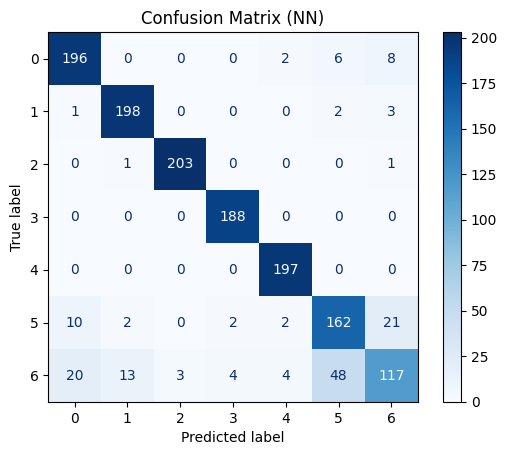

In [238]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

classifier_accuracy = round(accuracy_score(y_test, y_pred), 2)

print(f"Accuracy of NN: {classifier_accuracy}%")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix (NN)")
plt.show()